# Part 1: Setup and Configuration

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import sys
from copy import deepcopy as copy

import torch
from torch import nn
from torch.autograd import Variable
from torch.functional import F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torch_geometric.nn import MetaLayer, MessagePassing
from torch_geometric.data import Data, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm

In [2]:
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
sys.path.append("/Users/lanag/Desktop/Empirical_Flocking_Learning/utils")
import LaGNA_flocks
import Self_func
import Interaction_func
from LaGNA_flocks import *
from Self_func import *
from Interaction_func import *

## Configuration Parameters

In [4]:
USE_CUDA = False
model = 'flocks'
delt_t = 0.01

## Data Loading and Preprocessing

In [5]:
# ============================================================================
# chose from: 'hf1', 'hf2', 'hf3', 'hf4'
DATASET = 'hf3'

print("Loading data...")

timeseries_path = f'/Users/lanag/Desktop/Empirical_Flocking_Learning/Data/flocks_timeseries_2dim_{DATASET}.csv'
adj_path = f'/Users/lanag/Desktop/Empirical_Flocking_Learning/Data/adj_{DATASET}.csv'

Timeseries = pd.read_csv(timeseries_path, encoding='utf-8', header=None)
Adj = pd.read_csv(adj_path, encoding='utf-8', header=None)

Num_nodes = Adj.shape[0]
Dimension = int(Timeseries.shape[1] / Num_nodes)
print(f"Dataset: '{DATASET}', Number of nodes: {Num_nodes}, Dimension: {Dimension}")

Loading data...
Dataset: 'hf3', Number of nodes: 7, Dimension: 2


In [6]:
print("Preprocessing data...")
time = Timeseries.values
timeseries = time.reshape((-1, Num_nodes, Dimension))

timeseries_t0 = timeseries[0:-1, :, :]
timeseries_t1 = timeseries[1:, :, :]
dX = (timeseries_t1 - timeseries_t0)
dXdt = (timeseries_t1 - timeseries_t0) / delt_t

timeseries_t2 = timeseries[2:, :, :]
dVdt = (timeseries_t2 - 2*timeseries_t1[:-1, :, :] + timeseries[0:-2, :, :]) / delt_t**2

Preprocessing data...


In [7]:
def get_edge_index(Adj):
    num_nodes = Adj.shape[0]
    Adj_array = Adj.values
    edge_index = torch.from_numpy(np.array(np.where(Adj_array)))
    return edge_index

In [8]:
edge_index = get_edge_index(Adj)  # target to source
index = [1, 0]
edge_index = edge_index[index]  # source to target

In [9]:
goal_data = np.concatenate([timeseries[3:, :, :], dXdt[1:-1, :, :], dVdt[:-1, :, :]], axis=2)
mapping_data = np.concatenate((timeseries[1:-2, :, :], dXdt[0:-2, :, :]), axis=2)

In [10]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

In [12]:
print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")

Training set size: 71998, Test set size: 18000


# Model Training

In [13]:
print("Initializing model...")
aggr = 'add'
hidden = 100
msg_dim = 3
n_f = mapping_data.shape[2]
dim = Dimension * 1

Initializing model...


In [14]:
ogn = SDI_Difftype(model, n_f, msg_dim, dim, delt_t, hidden=hidden, 
                   edge_index=edge_index, aggr=aggr)

In [15]:
batch = 64
trainloader = DataLoader(
    [Data(Variable(X_train[i]), edge_index=edge_index, y=Variable(y_train[i])) 
     for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(X_test[i], edge_index=edge_index, y=y_test[i]) 
     for i in range(len(y_test))],
    batch_size=128,
    shuffle=True
)

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [16]:
test_idxes = np.random.randint(0, len(X_test), 1000)
newtestloader = DataLoader(
    [Data(X_test[i], edge_index=edge_index, y=y_test[i]) 
     for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)

In [17]:
def get_messages(ogn):
    """capture the message"""
    def get_message_info(tmp):
        ogn.cpu()
        s1 = tmp.x[tmp.edge_index[0]]  # source
        s2 = tmp.x[tmp.edge_index[1]]  # target
        
        xtmp = (s1[:, 0:dim] - s2[:, 0:dim])
        vtmp = (s1[:, dim:dim*2] - s2[:, dim:dim*2])
        
        if dim == 1:
            Xtmp = torch.sqrt((s1[:, 0] - s2[:, 0])**2)
        if dim == 2:
            Xtmp = torch.sqrt((s1[:, 0] - s2[:, 0])**2 + (s1[:, 1] - s2[:, 1])**2)
        if dim == 3:
            Xtmp = torch.sqrt((s1[:, 0] - s2[:, 0])**2 + (s1[:, 1] - s2[:, 1])**2 + 
                            (s1[:, 2] - s2[:, 2])**2)
        
        cohesion = ogn.msg_fnc_cohesion(Xtmp.reshape(-1, 1))
        align = ogn.msg_fnc_align(Xtmp.reshape(-1, 1))
        
        all_messages = torch.cat((xtmp, vtmp, cohesion, align), dim=1)
        
        if dim == 1:
            columns = ['xij', 'dxij', 'c1', 'a1']
        if dim == 2:
            columns = ['xij', 'yij', 'dxij', 'dyij', 'c1', 'a1']
        elif dim == 3:
            columns = ['xij', 'yij', 'zij', 'dxij', 'dyij', 'dzij', 'c1', 'a1']
        
        return pd.DataFrame(data=all_messages.cpu().detach().numpy(), columns=columns)
    
    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))
    msg_info = pd.concat(msg_info)
    return msg_info


def get_diffusion(ogn):
    """capture the diffusion"""
    def get_diffusion_info(tmp):
        ogn.cpu()
        tmp = tmp.x[tmp.edge_index[1]]
        
        if dim == 1:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_all = torch.cat((tmp, self_diff_x), dim=1)
            columns = ['xi', 'dxi', 'd1']
        if dim == 2:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_all = torch.cat((tmp, self_diff_x, self_diff_y), dim=1)
            columns = ['xi', 'yi', 'dxi', 'dyi', 'd1', 'd2']
        if dim == 3:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_z = ogn.stochastic_z(tmp)
            self_diff_all = torch.cat((tmp, self_diff_x, self_diff_y, self_diff_z), dim=1)
            columns = ['xi', 'yi', 'zi', 'dxi', 'dyi', 'dzi', 'd1', 'd2', 'd3']
        
        return pd.DataFrame(data=self_diff_all.cpu().detach().numpy(), columns=columns)
    
    selfDiffusion_info = []
    for i, g in enumerate(newtestloader):
        selfDiffusion_info.append(get_diffusion_info(g))
    selfDiffusion_info = pd.concat(selfDiffusion_info)
    return selfDiffusion_info


def get_selfDynamics(ogn):
    """capture the self- dynamics"""
    def get_selfDynamics_info(tmp):
        ogn.cpu()
        tmp = tmp.x[tmp.edge_index[1]]
        
        if dim == 1:
            vtmp = torch.sqrt(tmp[:, 1]**2)
            self_dyn = ogn.node_fnc_strength(vtmp.reshape(-1, 1))
            self_dyn_all = torch.cat((tmp[:, 1:2], self_dyn), dim=1)
            columns = ['dxi', 's1']
        if dim == 2:
            vtmp = tmp[:, 2]**2 + tmp[:, 3]**2
            vxtmp = torch.cat((vtmp.reshape(-1, 1), tmp[:, 2].reshape(-1, 1)), dim=1)
            vytmp = torch.cat((vtmp.reshape(-1, 1), tmp[:, 3].reshape(-1, 1)), dim=1)
            self_dyn_x = ogn.node_fnc_strength_x(vxtmp)
            self_dyn_y = ogn.node_fnc_strength_y(vytmp)
            self_dyn_all = torch.cat((vtmp.reshape(-1, 1), tmp[:, 2:4], 
                                     self_dyn_x, self_dyn_y), dim=1)
            columns = ['Vi', 'dxi', 'dyi', 's1', 's2']
        if dim == 3:
            vtmp = torch.sqrt(tmp[:, 3]**2 + tmp[:, 4]**2 + tmp[:, 5]**2)
            self_dyn = ogn.node_fnc_strength(vtmp.reshape(-1, 1))
            self_dyn_all = torch.cat((tmp[:, 3:6], self_dyn), dim=1)
            columns = ['dxi', 'dyi', 'dzi', 's1']
        
        return pd.DataFrame(data=self_dyn_all.cpu().detach().numpy(), columns=columns)
    
    selfDyn_info = []
    for i, g in enumerate(newtestloader):
        selfDyn_info.append(get_selfDynamics_info(g))
    selfDyn_info = pd.concat(selfDyn_info)
    return selfDyn_info

In [18]:
print("Starting training...")
init_lr = 1e-4
opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)
total_epochs = 30
batch_per_epoch = 2000
sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

messages_over_time = []
selfDyn_over_time = []
diffusion_over_time = []
recorded_models = []
epoch = 0

for epoch in tqdm(range(epoch, total_epochs)):
    ogn.train()
    total_loss = 0.0
    i = 0
    j = 0
    num_items = 0
    valid_loss = 0
    valid_num_items = 0
    
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x
            ginput.y = ginput.y
            ginput.edge_index = ginput.edge_index
            ginput.batch = ginput.batch
            loss = ogn.loss(ginput)
            loss.backward()
            opt.step()
            sched.step()
            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1] + 1)
    
    ogn.eval()
    with torch.no_grad():
        while j < batch_per_epoch:
            for ginput in testloader:
                if j >= batch_per_epoch:
                    break
                ginput.x = ginput.x
                ginput.y = ginput.y
                ginput.edge_index = ginput.edge_index
                ginput.batch = ginput.batch
                loss = ogn.loss(ginput)
                valid_loss += loss.item()
                valid_num_items += int(ginput.batch[-1] + 1)
                j += 1
    
    cur_loss = total_loss / num_items
    cur_valid_loss = valid_loss / valid_num_items
    print(f"Epoch {epoch}: Train Loss = {cur_loss:.4f}, Valid Loss = {cur_valid_loss:.4f}")
    
    cur_msgs = get_messages(ogn)
    cur_selfdyn = get_selfDynamics(ogn)
    cur_diff = get_diffusion(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    selfDyn_over_time.append(cur_selfdyn)
    diffusion_over_time.append(cur_diff)
    
    ogn.cpu()
    recorded_models.append(copy(ogn.state_dict()))

print("Training completed!")

Starting training...


  0%|                                                          | 0/30 [00:00<?, ?it/s]

Epoch 0: Train Loss = 68.5750, Valid Loss = 6.1077


  3%|█▋                                                | 1/30 [01:36<46:35, 96.38s/it]

Epoch 1: Train Loss = 4.2341, Valid Loss = 1.4487


  7%|███▎                                              | 2/30 [03:12<45:01, 96.49s/it]

Epoch 2: Train Loss = -4.8036, Valid Loss = -13.9940


 10%|█████                                             | 3/30 [04:50<43:34, 96.82s/it]

Epoch 3: Train Loss = -32.3275, Valid Loss = -56.8269


 13%|██████▋                                           | 4/30 [06:26<41:52, 96.65s/it]

Epoch 4: Train Loss = -94.2565, Valid Loss = -129.0834


 17%|████████▎                                         | 5/30 [08:05<40:40, 97.63s/it]

Epoch 5: Train Loss = -126.9850, Valid Loss = -133.9145


 20%|██████████                                        | 6/30 [09:45<39:15, 98.13s/it]

Epoch 6: Train Loss = -131.6442, Valid Loss = -136.3956


 23%|███████████▋                                      | 7/30 [11:22<37:32, 97.95s/it]

Epoch 7: Train Loss = -129.0158, Valid Loss = -131.5086


 27%|█████████████▎                                    | 8/30 [13:01<36:03, 98.33s/it]

Epoch 8: Train Loss = -134.2157, Valid Loss = -139.2501


 30%|███████████████                                   | 9/30 [14:40<34:24, 98.32s/it]

Epoch 9: Train Loss = -132.9551, Valid Loss = -137.6719


 33%|████████████████▎                                | 10/30 [16:18<32:45, 98.29s/it]

Epoch 10: Train Loss = -135.4197, Valid Loss = -138.7023


 37%|█████████████████▉                               | 11/30 [17:56<31:09, 98.41s/it]

Epoch 11: Train Loss = -137.5561, Valid Loss = -143.6158


 40%|███████████████████▌                             | 12/30 [19:34<29:29, 98.28s/it]

Epoch 12: Train Loss = -139.0109, Valid Loss = -145.3519


 43%|█████████████████████▏                           | 13/30 [21:11<27:39, 97.62s/it]

Epoch 13: Train Loss = -141.8812, Valid Loss = -127.3488


 47%|██████████████████████▊                          | 14/30 [22:47<25:55, 97.22s/it]

Epoch 14: Train Loss = -142.4709, Valid Loss = -146.7209


 50%|████████████████████████▌                        | 15/30 [24:24<24:16, 97.13s/it]

Epoch 15: Train Loss = -145.6408, Valid Loss = -148.5568


 53%|██████████████████████████▏                      | 16/30 [26:02<22:42, 97.32s/it]

Epoch 16: Train Loss = -149.9580, Valid Loss = -143.8789


 57%|███████████████████████████▊                     | 17/30 [27:39<21:04, 97.28s/it]

Epoch 17: Train Loss = -151.8944, Valid Loss = -150.0851


 60%|█████████████████████████████▍                   | 18/30 [29:16<19:28, 97.35s/it]

Epoch 18: Train Loss = -153.5848, Valid Loss = -158.7360


 63%|███████████████████████████████                  | 19/30 [30:54<17:52, 97.48s/it]

Epoch 19: Train Loss = -158.1216, Valid Loss = -160.9895


 67%|████████████████████████████████▋                | 20/30 [32:32<16:15, 97.53s/it]

Epoch 20: Train Loss = -160.7797, Valid Loss = -163.8641


 70%|██████████████████████████████████▎              | 21/30 [34:10<14:39, 97.67s/it]

Epoch 21: Train Loss = -163.5627, Valid Loss = -163.5204


 73%|███████████████████████████████████▉             | 22/30 [35:50<13:07, 98.45s/it]

Epoch 22: Train Loss = -165.6533, Valid Loss = -168.7997


 77%|█████████████████████████████████████▌           | 23/30 [37:30<11:32, 98.91s/it]

Epoch 23: Train Loss = -167.7056, Valid Loss = -169.5007


 80%|███████████████████████████████████████▏         | 24/30 [39:09<09:53, 98.98s/it]

Epoch 24: Train Loss = -168.4354, Valid Loss = -163.8864


 83%|████████████████████████████████████████▊        | 25/30 [40:46<08:11, 98.34s/it]

Epoch 25: Train Loss = -169.6816, Valid Loss = -170.9150


 87%|██████████████████████████████████████████▍      | 26/30 [42:22<06:30, 97.74s/it]

Epoch 26: Train Loss = -170.5292, Valid Loss = -171.2950


 90%|████████████████████████████████████████████     | 27/30 [43:58<04:51, 97.24s/it]

Epoch 27: Train Loss = -171.0031, Valid Loss = -170.4415


 93%|█████████████████████████████████████████████▋   | 28/30 [45:35<03:13, 96.94s/it]

Epoch 28: Train Loss = -171.3835, Valid Loss = -171.7095


 97%|███████████████████████████████████████████████▎ | 29/30 [47:11<01:36, 96.74s/it]

Epoch 29: Train Loss = -171.5404, Valid Loss = -171.7787


100%|█████████████████████████████████████████████████| 30/30 [48:47<00:00, 97.58s/it]

Training completed!


#  Trajectory Generation and Visualization

In [19]:
ogn.cpu()
ogn.load_state_dict(recorded_models[-1])

<All keys matched successfully>

## Save the model (optional)

In [28]:
# SAVE_DIR = ".../Empirical_Flocking_Learning/Parameter_Configurations"
# if not os.path.exists(SAVE_DIR):
#     os.makedirs(SAVE_DIR)

# MODEL_FILENAME = f"ogn_model_{DATASET}_final.pth" 
# MODEL_SAVE_PATH = os.path.join(SAVE_DIR, MODEL_FILENAME)

# final_model_state = recorded_models[-1]

# torch.save(final_model_state, MODEL_SAVE_PATH)

# print(f"Final model parameters saved to: {MODEL_SAVE_PATH}")

## Load the saved model (optional)

In [29]:
# print("Initializing a new model instance...")
# ogn = SDI_Difftype(
#     model=MODEL_NAME, 
#     n_f=n_features, 
#     msg_dim=MSG_DIM,
#     ndim=dim, 
#     delt_t=DELT_T, 
#     hidden=HIDDEN_DIM,
#     edge_index=edge_index, 
#     aggr=AGGR_METHOD
# )

# SAVE_DIR = ".../Empirical_Flocking_Learning/Parameter_Configurations"
# MODEL_FILENAME = f"ogn_model_{DATASET}_final.pth" 
# MODEL_LOAD_PATH = os.path.join(SAVE_DIR, MODEL_FILENAME)

# print(f"Loading model parameters from: {MODEL_LOAD_PATH}")

# state_dict = torch.load(MODEL_LOAD_PATH, map_location=torch.device('cpu'))

# ogn.load_state_dict(state_dict)

# ogn.eval()

In [20]:
print("Generating inferred trajectories...")
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))

x_Update = []
y_Update = []
vx_Update = []
vy_Update = []

for i in range(0, 20000):
    _q = Data(x=X[i].float(), edge_index=edge_index, y=y[i].float())
    x_tmp, v_tmp = ogn.sample_trajectories(_q)
    
    if i < X.shape[0] - 2:
        X[i+2, :, 0:dim] = x_tmp
        X[i+1, :, dim:] = v_tmp
    else:
        break
    
    x_Update.append(x_tmp[:, 0].reshape(1, -1))
    y_Update.append(x_tmp[:, 1].reshape(1, -1))
    vx_Update.append(v_tmp[:, 0].reshape(1, -1))
    vy_Update.append(v_tmp[:, 1].reshape(1, -1))

x_i = torch.stack(x_Update, dim=0).reshape(-1, Num_nodes)
y_i = torch.stack(y_Update, dim=0).reshape(-1, Num_nodes)
vx_i = torch.stack(vx_Update, dim=0).reshape(-1, Num_nodes)
vy_i = torch.stack(vy_Update, dim=0).reshape(-1, Num_nodes)

print("Trajectory generation completed!")

Generating inferred trajectories...
Trajectory generation completed!


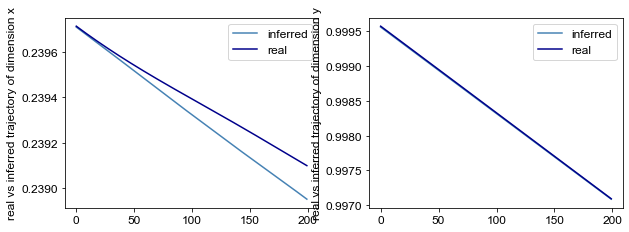

In [21]:
# Visualize one bird's trajectory
time1 = pd.read_csv(timeseries_path, encoding='utf-8', header=None)

Nindex = 0
TIME = 200
x_tra = x_i.detach().numpy()[0:TIME, Nindex-1]
x_real = time1.iloc[0:, Nindex*2-2]

fig = plt.figure(figsize=(10, 3.5))
ax1 = fig.add_subplot(1, 2, 1)
t = np.arange(0, x_tra.shape[0])
ax1.plot(t, x_tra, c='steelblue', label="inferred")
ax1.plot(t, x_real[2:x_tra.shape[0]+2,], c='darkblue', label="real")
plt.ylabel('real vs inferred trajectory of dimension x')
plt.legend()

ax2 = fig.add_subplot(1, 2, 2)
y_tra = y_i.detach().numpy()[0:TIME, Nindex-1]
y_real = time1.iloc[0:, Nindex*2-1]
t = np.arange(0, y_tra.shape[0])
ax2.plot(t, y_tra, c='steelblue', label="inferred")
ax2.plot(t, y_real[2:y_tra.shape[0]+2,], c='darkblue', label="real")
plt.ylabel('real vs inferred trajectory of dimension y')
plt.legend()
plt.show()

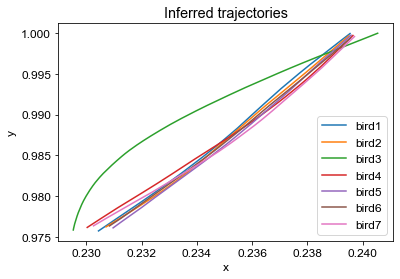

In [22]:
r = np.linspace(0, 200, 20000)
TIME = 2000
fig, ax = plt.subplots()

for bird_idx in range(Num_nodes):
    x_bird = x_i.detach().numpy()[0:TIME, bird_idx]
    y_bird = y_i.detach().numpy()[0:TIME, bird_idx]
    ax.plot(x_bird, y_bird, label=f'bird{bird_idx+1}')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Inferred trajectories')
ax.legend()
plt.show()

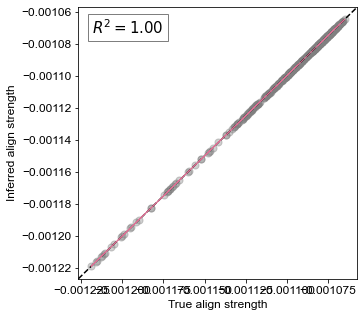

In [23]:
bestMe = messages_over_time[-1]
rij_val = np.sqrt(bestMe['xij'].values**2 + bestMe['yij'].values**2)
align_true = np.exp(-rij_val/3)

maxy = np.max(bestMe['a1'].values)
miny = np.min(bestMe['a1'].values)
maxx = np.max(align_true)
minx = np.min(align_true)
align_true_norm = (maxy - miny) * (align_true - minx) / (maxx - minx) + miny

correlation = np.corrcoef(align_true_norm, bestMe['a1'].values)[0, 1]
const = 1 if correlation > 0 else -1
align_true = const * align_true_norm

# get the coefficient for the alignment part
d = const*(maxy - miny)/(maxx - minx)
e = -minx
f = const*miny

sx = bestMe['a1'].values[0:1000]
sx_true = align_true[0:1000]

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(1, 1, 1)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, 
                   wspace=None, hspace=0.5)
ax1.scatter(sx_true, sx, s=50, c='grey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--', c='k', label="1:1 line")
parameterx = np.polyfit(sx_true, sx, 1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true, fx(sx_true), c='palevioletred', lw=1)
corrx = np.corrcoef(sx_true, sx)[0, 1]
bbox = dict(fc='1', alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, 
        size=15, bbox=bbox)
plt.xlabel("True align strength")
plt.ylabel("Inferred align strength")
plt.show()

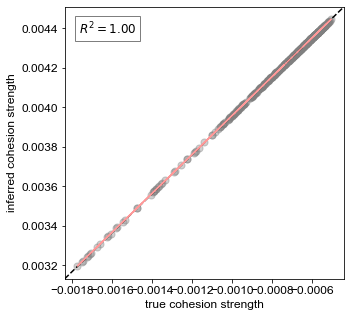

In [24]:
coup_value = ((rij_val/2-1)**3/(1+rij_val/2)**6) + 1

maxy = np.max(bestMe['c1'].values)
miny = np.min(bestMe['c1'].values)
maxx = np.max(coup_value)
minx = np.min(coup_value)
coup_value_norm = (maxy - miny) * (coup_value - minx) / (maxx - minx) + miny
correlation = np.corrcoef(coup_value_norm, bestMe['c1'].values)[0, 1]
const = 1 if correlation > 0 else -1
coup_value = const*coup_value_norm

# get the coefficient for cohesion part
 

b = 1-minx
p = const*(maxy - miny)/(maxx - minx)
c = const*miny

temp = bestMe['c1'].values[0:1000]
coup_value_plot = coup_value[0:1000]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(coup_value_plot, temp, s=50, c='grey', alpha=0.2)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--', c='k', label="1:1 line")
parameter = np.polyfit(coup_value_plot, temp, 1)
f = np.poly1d(parameter)
ax.plot(coup_value_plot, f(coup_value_plot), c='#ff9999', lw=1.5)
corr = np.corrcoef(coup_value_plot, temp)[0, 1]
bbox = dict(fc='1', alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corr**2), transform=ax.transAxes, 
        size=12, bbox=bbox)
plt.xlabel("true cohesion strength")
plt.ylabel("inferred cohesion strength")
plt.show()

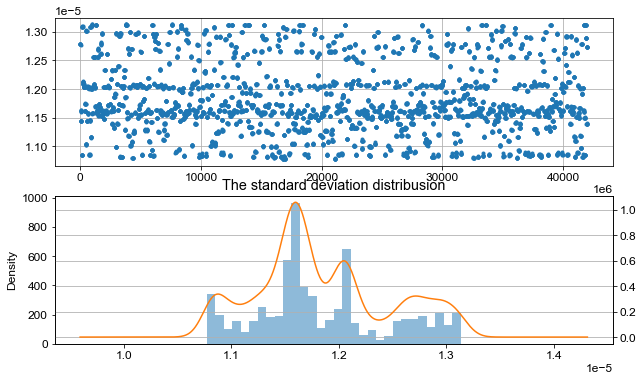

In [25]:
diffusion = diffusion_over_time[-1]
diffusion = pd.DataFrame(diffusion)
diffusion_new = pd.DataFrame.drop_duplicates(diffusion, subset=None, 
                                             keep='first', inplace=False)

s = diffusion_new['d1'] / np.sqrt(0.01)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(s.index, s.values, '.')
plt.grid()

ax2 = fig.add_subplot(2, 1, 2)
s.hist(bins=30, alpha=0.5, ax=ax2)
s.plot(kind='kde', secondary_y=True, ax=ax2)
plt.title('The standard deviation distribusion')
plt.grid()
plt.show()

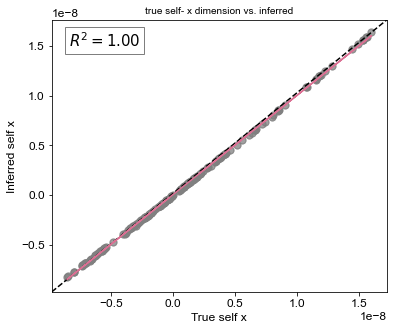

All visualizations completed!


In [26]:
best_selfDyn = selfDyn_over_time[-1]
best_selfDyn = pd.DataFrame(best_selfDyn)

self_true = (best_selfDyn['dxi']**2 + best_selfDyn['dyi']**2)

maxy = np.max(best_selfDyn['s1'].values)
miny = np.min(best_selfDyn['s1'].values)
maxx = np.max(self_true)
minx = np.min(self_true)
self_true_norm = (maxy - miny) * (self_true - minx) / (maxx - minx) + miny


sx = best_selfDyn['s1'].values * best_selfDyn['dxi']
sx_true_norm = self_true_norm * best_selfDyn['dxi']

correlation = np.corrcoef(sx_true_norm, sx)[0, 1]
const = 1 if correlation > 0 else -1
sx_true = const*sx_true_norm

# get the coefficient for self- dyn. part

m = -minx
g = const*(maxy - miny)/(maxx - minx)
r = const*miny


sx = sx[0:1000]
sx_true = sx_true[0:1000]

fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(1, 1, 1)
plt.title("true self- x dimension vs. inferred", fontsize=10)
ax1.scatter(sx_true, sx, s=50, c='grey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--', c='k', label="1:1 line")
parameterx = np.polyfit(sx_true, sx, 1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true, fx(sx_true), c='palevioletred', lw=1.5)
corrx = np.corrcoef(sx_true, sx)[0, 1]
bbox = dict(fc='1', alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, 
        size=15, bbox=bbox)
plt.xlabel("True self x")
plt.ylabel("Inferred self x")
plt.show()

print("All visualizations completed!")

# Post-processing and Error Statistics

Loading dataset: hf3


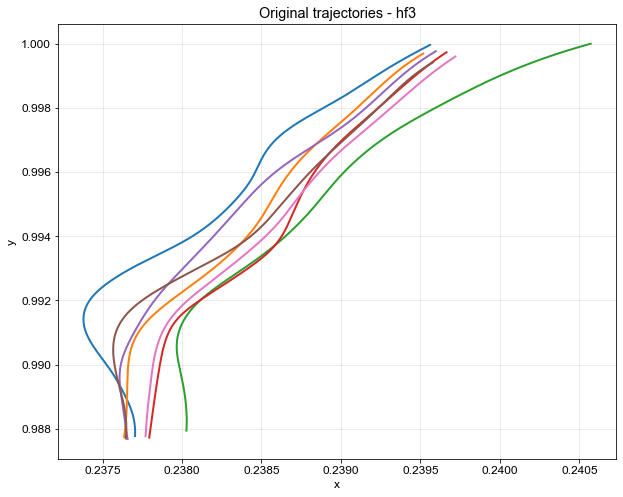


Coefficients for hf3:
  p = -0.1071591340676035, b = 0.9999933838844299, c = -0.0004999339580535889
  d = 0.17505946386097243, e = -0.9972178936004639, f =  
0.9858 x + 0.004946
  g = 0.49910206408739793, m = -7.199398055490747e-07, r = -1.4320015907287598e-05

Simulation parameters:
  Number of nodes: 7
  Time steps: 1000
  dt: 0.01

Running dynamics simulation...
Simulation completed!

POSITION ERROR ANALYSIS AT t=25

Position Error Statistics:
  Mean Error:   1.722668e-05
  Std Error:    8.522135e-06
  Max Error:    3.551211e-05
  Min Error:    4.878971e-06

Per-Agent Position Errors:
  Agent 0: 4.878971e-06
  Agent 1: 1.570540e-05
  Agent 2: 3.551211e-05
  Agent 3: 1.555493e-05
  Agent 4: 1.346283e-05
  Agent 5: 1.867694e-05
  Agent 6: 1.679558e-05

2. RELATIVE ERRORS (normalized by position magnitude)
  Mean:    0.000017 (0.00%)
  Std:     0.000008
  Max:     0.000035 (0.00%)
  Min:     0.000005 (0.00%)


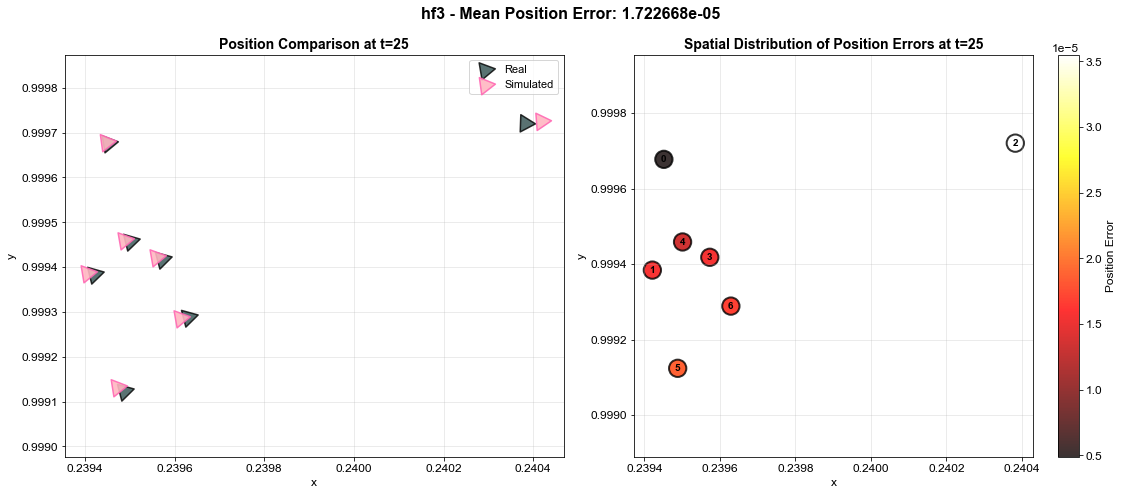

In [27]:
from matplotlib import patches
import warnings
warnings.filterwarnings('ignore')

print(f"Loading dataset: {DATASET}")
data_file = f'/Users/lanag/Desktop/Empirical_Flocking_Learning/Data/flocks_timeseries_2dim_{DATASET}.csv'
data2norm = pd.read_csv(data_file, header=None).values

dt = 0.01
data2v = (data2norm[1:, :] - data2norm[:-1, :]) / dt

plt.figure(figsize=(10, 8))
for i in range(data2norm.shape[1] // 2):
    plt.plot(data2norm[:1000, i*2], data2norm[:1000, i*2+1], linewidth=2)
plt.title(f'Original trajectories - {DATASET}')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, alpha=0.3)
plt.show()

# coefficients (optional)
coefficients = {
    'hf1': {
        'p': -0.0070417263,
        'b': 0.9400337338447571,
        'c': 0.000451006,
        'd': 0.60338336,
        'e': -0.9954246,
        'f': -0.0032163374,
        'g': 1.9591489127252002,
        'm': -1.2232491144459345e-06,
        'r': -1.5962869e-05
    },
    'hf2': {
        'p': 0.18648678,
        'b': 0.9999883770942688,
        'c': 0.0037961379,
        'd': -0.20306803,
        'e': 0.99999917,
        'f': -4.2576343e-05,
        'g': 6.167326581717668,
        'm': -1.331904513790505e-06,
        'r': -5.1870942e-05
    },
    'hf3': {
        'p': -0.106570505,
        'b': 0.9631454944610596,
        'c': 0.00034091622,
        'd': 0.004008455,
        'e': -0.99722046,
        'f': 0.0011027143,
        'g': 0.29124801565443115,
        'm': -7.389401162072318e-07,
        'r': -5.2824616e-06
    },
    'hf4': {
        'p': -0.01368125,
        'b': 0.9843001,
        'c': 0.0025799908,
        'd': 0.1316837,
        'e': -0.9988282,
        'f': 0.00062561035,
        'g': 1.7975674649230606,
        'm': -8.477218784719298e-07,
        'r': 7.459521e-05
    }
}

# coef = coefficients[DATASET]
# p, b, c = coef['p'], coef['b'], coef['c']
# d, e, f = coef['d'], coef['e'], coef['f']
# g, m, r = coef['g'], coef['m'], coef['r']

# print(f"\nCoefficients for {DATASET}:")
# for key, value in coef.items():
#     print(f"  {key} = {value:.10e}")

######### Coefficients from the above learning process #######
print(f"\nCoefficients for {DATASET}:")
print(f"  p = {p}, b = {b}, c = {c}")
print(f"  d = {d}, e = {e}, f = {f}")
print(f"  g = {g}, m = {m}, r = {r}")

N = data2norm.shape[1] // 2
Time = 1000 #len(data2norm)
Nnodes = N
dim = 2

#np.random.seed(42)  
s = np.random.normal(0, np.sqrt(dt), (Time, Nnodes * dim)) * 5e-5


A = np.ones((Nnodes, Nnodes))
np.fill_diagonal(A, 0)

R = np.zeros((Time, dim * Nnodes))
V = np.zeros((Time, dim * Nnodes))
dVdt = np.zeros((Time, dim * Nnodes))

R[0, :] = data2norm[0, :]
V[0, :] = (data2norm[1, :] - data2norm[0, :]) / dt

print(f"\nSimulation parameters:")
print(f"  Number of nodes: {Nnodes}")
print(f"  Time steps: {Time}")
print(f"  dt: {dt}")
print("\nRunning dynamics simulation...")

for t in range(1, Time):
#     if t % 1000 == 0:
#         print(f"  Progress: {t}/{Time}")
    
    for i in range(Nnodes):
        tmp = np.zeros(dim)
        
        for j in range(Nnodes):
            rij = np.sqrt((R[t-1, 2*i] - R[t-1, 2*j])**2 + 
                         (R[t-1, 2*i+1] - R[t-1, 2*j+1])**2)
            
            Rij = np.array([R[t-1, 2*j] - R[t-1, 2*i],
                           R[t-1, 2*j+1] - R[t-1, 2*i+1]])
            Vij = np.array([V[t-1, 2*j] - V[t-1, 2*i],
                           V[t-1, 2*j+1] - V[t-1, 2*i+1]])
            
            if rij <= 0.1:
                cohesion_term = (p * ((rij/2 - 1)**3 / (rij/2 + 1)**6 + b) + c) * Rij
                align_term = (d * (np.exp(-rij/3) + e) + f) * Vij
                tmp = tmp + A[i, j] * (cohesion_term + align_term)
        
        Vi = np.array([V[t-1, 2*i], V[t-1, 2*i+1]])
        S = np.array([s[t, 2*i], s[t, 2*i+1]])
        vi = np.sqrt(V[t-1, 2*i]**2 + V[t-1, 2*i+1]**2)
        
        a = (g * (vi + m) + r) * Vi + tmp
        
        dVdt[t-1, 2*i:2*i+2] = a
        V[t, 2*i:2*i+2] = V[t-1, 2*i:2*i+2] + a * dt + S
        R[t, 2*i:2*i+2] = R[t-1, 2*i:2*i+2] + V[t-1, 2*i:2*i+2] * dt

print("Simulation completed!")

TT = 25
print(f"\n{'='*70}")
print(f"POSITION ERROR ANALYSIS AT t={TT}")
print(f"{'='*70}\n")

R_sim = R[TT, :].reshape(Nnodes, 2)  
R_real = data2norm[TT, :].reshape(Nnodes, 2)  

position_errors = np.sqrt((R_sim[:, 0] - R_real[:, 0])**2 + 
                         (R_sim[:, 1] - R_real[:, 1])**2)

print("Position Error Statistics:")
print(f"  Mean Error:   {np.mean(position_errors):.6e}")
print(f"  Std Error:    {np.std(position_errors):.6e}")
print(f"  Max Error:    {np.max(position_errors):.6e}")
print(f"  Min Error:    {np.min(position_errors):.6e}")

print(f"\nPer-Agent Position Errors:")
for i in range(Nnodes):
    print(f"  Agent {i}: {position_errors[i]:.6e}")

    
R_real_norm = np.sqrt(R_real[:, 0]**2 + R_real[:, 1]**2)
relative_errors_norm = position_errors / (R_real_norm + 1e-10) 

print(f"\n{'='*70}")
print("2. RELATIVE ERRORS (normalized by position magnitude)")
print("="*70)
print(f"  Mean:    {np.mean(relative_errors_norm):.6f} ({np.mean(relative_errors_norm)*100:.2f}%)")
print(f"  Std:     {np.std(relative_errors_norm):.6f}")
print(f"  Max:     {np.max(relative_errors_norm):.6f} ({np.max(relative_errors_norm)*100:.2f}%)")
print(f"  Min:     {np.min(relative_errors_norm):.6f} ({np.min(relative_errors_norm)*100:.2f}%)")



Rv = (R[1:, :] - R[:-1, :]) / dt

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

ax1 = axes[0]

for i in range(Nnodes):
    vx_real = data2v[TT, 2*i]
    vy_real = data2v[TT, 2*i+1]
    angle_real = np.arctan2(vy_real, vx_real)  
    
    ax1.scatter(data2norm[TT, 2*i], data2norm[TT, 2*i+1], 
               marker=(3, 0, np.degrees(angle_real)-90),  
               s=400, c='#2F4F4F', edgecolors='black', linewidth=1.5,
               alpha=0.8, zorder=5, label='Real' if i == 0 else '')

for i in range(Nnodes):
    vx_sim = Rv[TT, 2*i]
    vy_sim = Rv[TT, 2*i+1]
    angle_sim = np.arctan2(vy_sim, vx_sim)  
    
    ax1.scatter(R[TT, 2*i], R[TT, 2*i+1], 
               marker=(3, 0, np.degrees(angle_sim)-90),  
               s=400, c='#FFB6C1', edgecolors='#FF69B4', linewidth=1.5,
               alpha=0.9, zorder=10, label='Simulated' if i == 0 else '')

ax1.set_title(f'Position Comparison at t={TT}', fontsize=14, fontweight='bold')
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

ax2 = axes[1]
scatter = ax2.scatter(R_real[:, 0], R_real[:, 1], 
                     c=position_errors, cmap='hot', 
                     s=300, alpha=0.8, edgecolors='black', linewidth=2)
plt.colorbar(scatter, ax=ax2, label='Position Error')

for i in range(Nnodes):
    ax2.text(R_real[i, 0], R_real[i, 1], f'{i}', 
            ha='center', va='center', fontsize=10, fontweight='bold')

ax2.set_title(f'Spatial Distribution of Position Errors at t={TT}', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('y', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

plt.suptitle(f'{DATASET} - Mean Position Error: {np.mean(position_errors):.6e}', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()